In [3]:
#Array, image processing
import cv2
import numpy as np
import matplotlib.pyplot as plt 
#Model Operation
from keras import Model, Input
import keras.utils as image
from keras.wrappers.scikit_learn import KerasRegressor
from tensorflow.keras.layers import Dense, Conv2D, MaxPool2D, UpSampling2D
from tensorflow.keras.callbacks import EarlyStopping
from sklearn.model_selection import train_test_split
from sklearn.model_selection import GridSearchCV
from sklearn import metrics
# io
import glob
from tqdm import tqdm
import warnings;
warnings.filterwarnings('ignore')

#GPU 
import os

In [11]:
os.environ["CUDA_VISIBLE_DEVICES"] = "0"  

# Define the path to the folder containing your image files
folder_path = '../lab4/face_mini/'

# Define the file pattern for the images you want to read (e.g., *.jpg)
file_pattern = '**/*.jpg'

# Use glob.glob to find all image files that match the pattern within the specified folder and its subdirectories
image_files = glob.glob(f'{folder_path}{file_pattern}', recursive=True)

# Initialize a list to store NumPy arrays of the images
images = []

# Loop through the image files, read them, and convert them to NumPy arrays
for file_path in image_files:
    # Read the image file using OpenCV
    img = cv2.cvtColor(cv2.imread(file_path), cv2.COLOR_BGR2RGB)
    
    # Resize the image to (100, 100) if needed
    img = cv2.resize(img, (80, 80), interpolation=cv2.INTER_NEAREST)
    
    # Append the image to the list
    images.append(img)

# Convert the list to a NumPy array
images_array = np.array(images)

# Normalize the images
images_array = images_array / 255.0

# Split the data into training, validation, and testing sets
train_x, test_x = train_test_split(images_array, test_size=0.3, random_state=42)
train_x, val_x = train_test_split(train_x, test_size=0.2, random_state=42)

# Define noise parameters
noise_mean = 0
noise_std = 0.3  
noise_factor = 0.6

# Create noise and add it to the images
train_x_noise = train_x + (noise_factor * np.random.normal(loc=noise_mean, scale=noise_std, size=train_x.shape))
val_x_noise = val_x + (noise_factor * np.random.normal(loc=noise_mean, scale=noise_std, size=val_x.shape))
test_x_noise = test_x + (noise_factor * np.random.normal(loc=noise_mean, scale=noise_std, size=test_x.shape))



In [9]:
def create_model(optimizer='adam'):
    # Variable input Image
    input_img = Input(shape=(80, 80, 3))
    print(input_img.shape)
    
    # Encoding
    x1 = Conv2D(256, (3, 3), activation='relu', padding='same')(input_img)
    x2 = Conv2D(128, (3, 3), activation='relu', padding='same')(x1)
    x2 = MaxPool2D((2, 2), strides=2)(x2)
    x3 = Conv2D(128, (3, 3), activation='relu', padding='same')(x3)
    x4 = Conv2D(64, (3, 3), activation='relu', padding='same')(x3)

    # Decoding
    x4 = Conv2D(64, (3, 3), activation='relu', padding='same')(x4)
    x3 = Conv2D(128(3,3), activation='relu', padding='same')(x4)
    x2 = UpSampling2D((2, 2))(x3)
    x2 = Conv2D(128, (3, 3), activation='relu', padding='same')(x3)
    x1 = Conv2D(256, (3, 3), activation='relu', padding='same')(x2)
    decoded = Conv2D(3, (3, 3), padding='same')(x1)

    # Construct the autoencoder model
    autoencoder = Model(input_img, decoded)
    autoencoder.compile(optimizer=optimizer, loss='mse', metrics=['mse'])
    autoencoder.summary()
    return autoencoder


In [24]:
e = [2,4,6,8,16]
b = [16,32,64,128]
autoencoder = create_model()

callback = EarlyStopping(monitor='loss', patience=3)
history = autoencoder.fit(train_x_noise, train_x,
   epochs=10,
   batch_size=16,
   shuffle=True,
   validation_data=(val_x_noise, val_x),
   callbacks=[callback],verbose=1)



(None, 80, 80, 3)
Model: "model_12"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_14 (InputLayer)       [(None, 80, 80, 3)]       0         
                                                                 
 conv2d_87 (Conv2D)          (None, 80, 80, 256)       7168      
                                                                 
 conv2d_88 (Conv2D)          (None, 80, 80, 128)       295040    
                                                                 
 max_pooling2d_13 (MaxPoolin  (None, 40, 40, 128)      0         
 g2D)                                                            
                                                                 
 conv2d_89 (Conv2D)          (None, 40, 40, 64)        73792     
                                                                 
 conv2d_90 (Conv2D)          (None, 40, 40, 64)        36928     
                                        

31/31 [==============================] - 3s 107ms/step


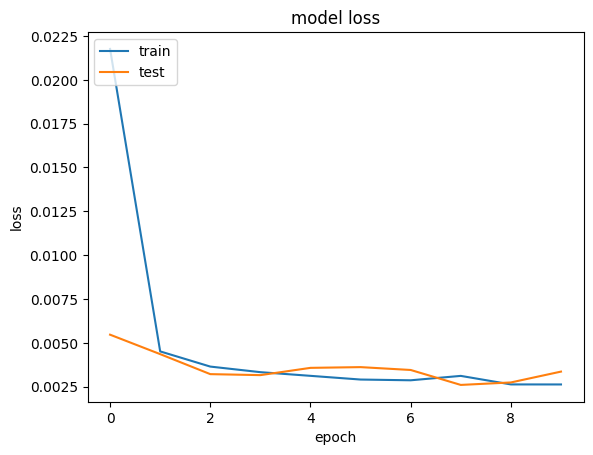

In [25]:
predictions_test = autoencoder.predict(test_x_noise)
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.show()

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


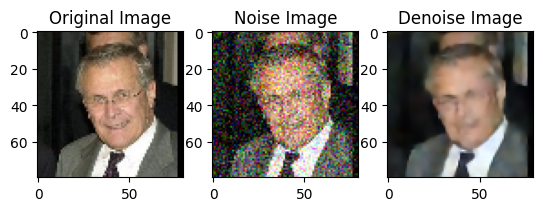

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


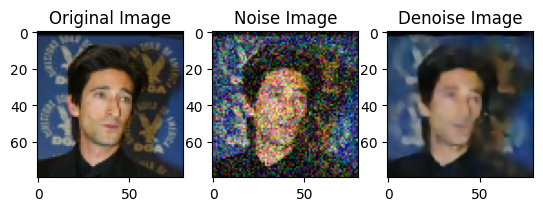

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


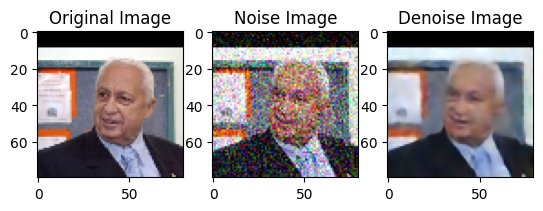

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


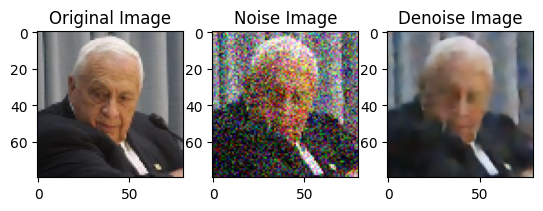

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


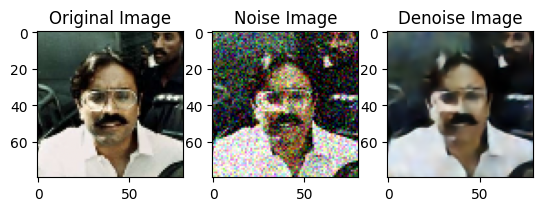

In [26]:
num_of_plot = 5

for i in range(num_of_plot):
    #Original Image
    plt.subplot(1, 3, 1)
    plt.title("Original Image")
    plt.imshow(test_x[i])

    #Noise Image
    plt.subplot(1,3,2)
    plt.title("Noise Image")
    plt.imshow(test_x_noise[i])

    #Denoise Image
    plt.subplot(1, 3, 3)
    plt.title("Denoise Image")
    plt.imshow(predictions_test[i])

    plt.show()